# Using optical flow to count bubbles and entrainment ocurrences.

This program was extracted from http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_video/py_lucas_kanade/py_lucas_kanade.html

It makes a matrix of  optical flow for each image each image.

In [223]:
import cv2
import os, fnmatch
import math
import glob
import numpy as np
import matplotlib.pyplot as plt

#Import the names of the Image Sequence to analyze
dirAos = '../hoose jet/19-sep-18/AOS/FLM210/'
pattern1 = "FLM210_p*.tif"
filenames=sorted(glob.glob(dirAos+pattern1))
frame_no = len(filenames)

#First frame for analysis
old_image=cv2.imread(filenames[1000])



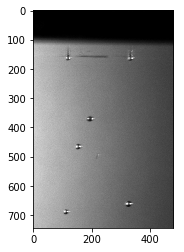

In [210]:
plt.imshow(old_image)
plt.show()

The image contains a big area that we do not want to analyze so we cut it to the interest area.
We also find small rectangles in this image to perform the analysis.

One rectangle close to the surface to count the ocurrences of air entrainment and one rectangle suffieciently far from the surface to count the bubles produced by the entrainment ocurrences. 

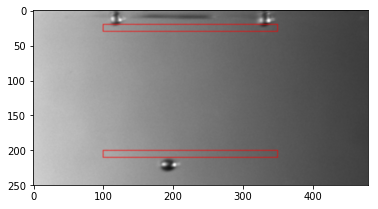

In [213]:
first_image = old_image[150:400, :]  #cut the part that is non relevant 
#view of the lines where the analysis is made
cv2.line(first_image,(100,20),(350,20),(255,0,0),1)  #rectangle for the entrainment area
cv2.line(first_image,(100,30),(350,30),(255,0,0),1)
cv2.line(first_image,(100,20),(100,30),(255,0,0),1)
cv2.line(first_image,(350,20),(350,30),(255,0,0),1)
cv2.line(first_image,(100,200),(350,200),(255,0,0),1) #rectangle for the bubble count
cv2.line(first_image,(100,210),(350,210),(255,0,0),1)
cv2.line(first_image,(100,200),(100,210),(255,0,0),1)
cv2.line(first_image,(350,200),(350,210),(255,0,0),1)
plt.imshow(first_image,interpolation='bicubic')
plt.show()

Now we use the opencv optical flow method to find the areas where there is movement in the image through time. similar to the cross-correlation in PIV.

We will obtain a velocity vector for each pixel in the image (u,v).

As we are only concerned about the movement in the vertical direction we will only analyze the v.
And as we only want to count entrainment and bubbles moving downwards, we will only consider positive values of v.  

In [215]:


#Parameter to see the optical flow animation, True to see it , False to hide it
see_animation = True 
# WARNING: even if the see_animtaion = False we need to press the enter key to close the animation window.

#We use hsv scale model to color the animation, we use only one color which means constant hue
# and total saturation 
hsv = np.zeros_like(first_image) #make hsv matrix 
hsv[...,0] = 180/np.pi/2 #One color in the hue chanel
hsv[...,1] = 255         #Total saturation

#images to analyze as a preview
init = 1000
finish = 1200
# Create the matrixes to store the optical flow
# 10 pixel rows in Y and 250 pixel columns in x, finish-init frames.
entrainment = np.zeros((10,250,finish-init))
bubs = np.zeros((10,250,finish-init))

#create animation window
cv2.namedWindow('frame', cv2.WINDOW_NORMAL)

#index to count frames when init is differrent than zero
count = 0
# Take first frame and transform it to gray
old_gray = cv2.cvtColor(first_image, cv2.COLOR_BGR2GRAY)
for i in range(init+1,finish):  
    image=cv2.imread(filenames[i]) #take image 
    image = image[150:400,:] #change to the desired size
    frame_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #transform to gray
    
#Optical Flow between old_gray and frame_gray given with velocities u,v. flow has shape (250,480,2) 
# 250*480 the size of the image and third index is 0 for u and 1 for v
    flow = cv2.calcOpticalFlowFarneback(old_gray,frame_gray, None, 0.5, 5, 5, 3, 5, 1.2, 1)
#Fill matrixes for entrainment and bubbles only with the information for the vertical velocities 
    for j in range(10):
        entrainment[j,:,count] += flow[20+j,100:350,1]
        bubs [j,:,count]= flow[200+j,100:350,1]
        
    # Now update the previous frame
    old_gray = frame_gray.copy()
    
    
#Turn on and off to see animation using True or False 
    if see_animation == True:
    #transformation to angle and magnitude to use hsv color code in image
        
        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1]) 
        hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX) # value channel fill with the magnitude
                                                                   # of the velocity vector
        rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR) #transform to rgb

        cv2.imshow('frame',rgb)
        k = cv2.waitKey(30) & 0xff
        if k == 27:
            break
    count+=1 #update index

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

Take a look of the data obtained for one frame, one plot for the entrainment and one plot for the bubbles

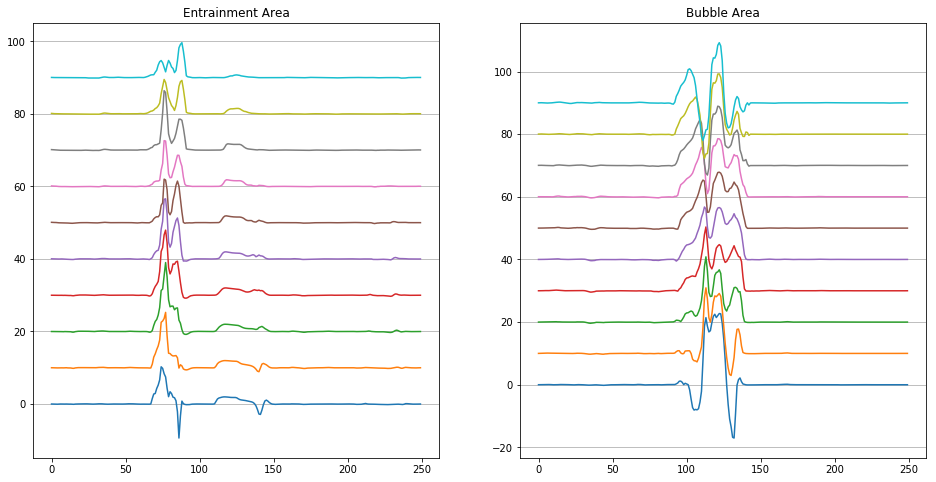

In [237]:
fig = plt.figure(figsize=(16,8))
#First axis for the left side
ax1 = plt.subplot(1,2,1)
plt.grid(True,axis='y')
ax1.set_title('Entrainment Area')
#Second axis for the right side
ax2 = plt.subplot(1,2,2)
ax2.grid(True,axis='y')
ax2.set_title('Bubble Area')
for i in range(10):
    ax1.plot(10*i+entrainment[i,:,35]) 
    ax2.plot(10*i+bubs[i,:,31])
    

We colapse this information in to one average to obtain a vector for each frame

In [241]:
average_ent = np.mean(entrainment,axis=0)
average_bub = np.mean(bubs,axis=0)
average_bub.shape, average_ent.shape,flow.shape

((250, 200), (250, 200), (250, 480, 2))

As we said before, we are only interested in positive values of the velocities so we can make zero any negative value in this arrays. 

Then we can color plot the field velocities in time to see if we can extract the ocurrences and bubbles

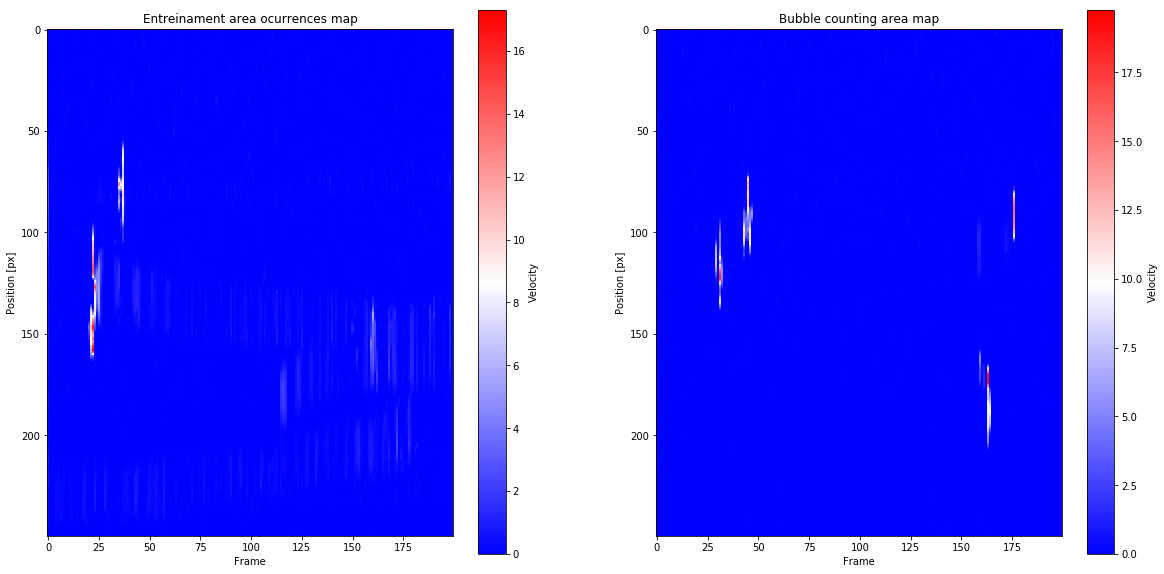

In [255]:
#We clip the negative values as we want only positive values of the optical flow
ave_positive = np.clip(average_ent,0,None)
bubs_positive = np.clip(average_bub,0,None)
#2D
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
#the color map represents the optical flow
im1 = plt.imshow(ave_positive,cmap='bwr',vmin=0,vmax=None )
cbar = plt.colorbar(im1,orientation='vertical')
cbar.set_label('Velocity')
plt.title('Entreinament area ocurrences map')
plt.xlabel('Frame')
plt.ylabel('Position [px]')

plt.subplot(1,2,2)
im2 = plt.imshow(bubs_positive,cmap='bwr',vmin=0,vmax=None )
cbar2 = plt.colorbar(im2,orientation='vertical')
cbar2.set_label('Velocity')
plt.title('Bubble counting area map')
plt.xlabel('Frame')
plt.ylabel('Position [px]')


plt.show()

We will like to find a way to detect the peaks in these 2d arrays, as these peaks represent the entrainment of air ocurrences and the bubbles passing respectively. We can check by lookking at the images that we have approximately 4 entrainment ocurrences and 4 bubbles passing.

A couple of routines to find 2D peaks has been found in:

https://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array

https://gist.github.com/endolith/250860

but still need to be implemented


Not complete after here

In [251]:
average= np.mean(bubs_positive, axis=1)
average.shape

(250,)

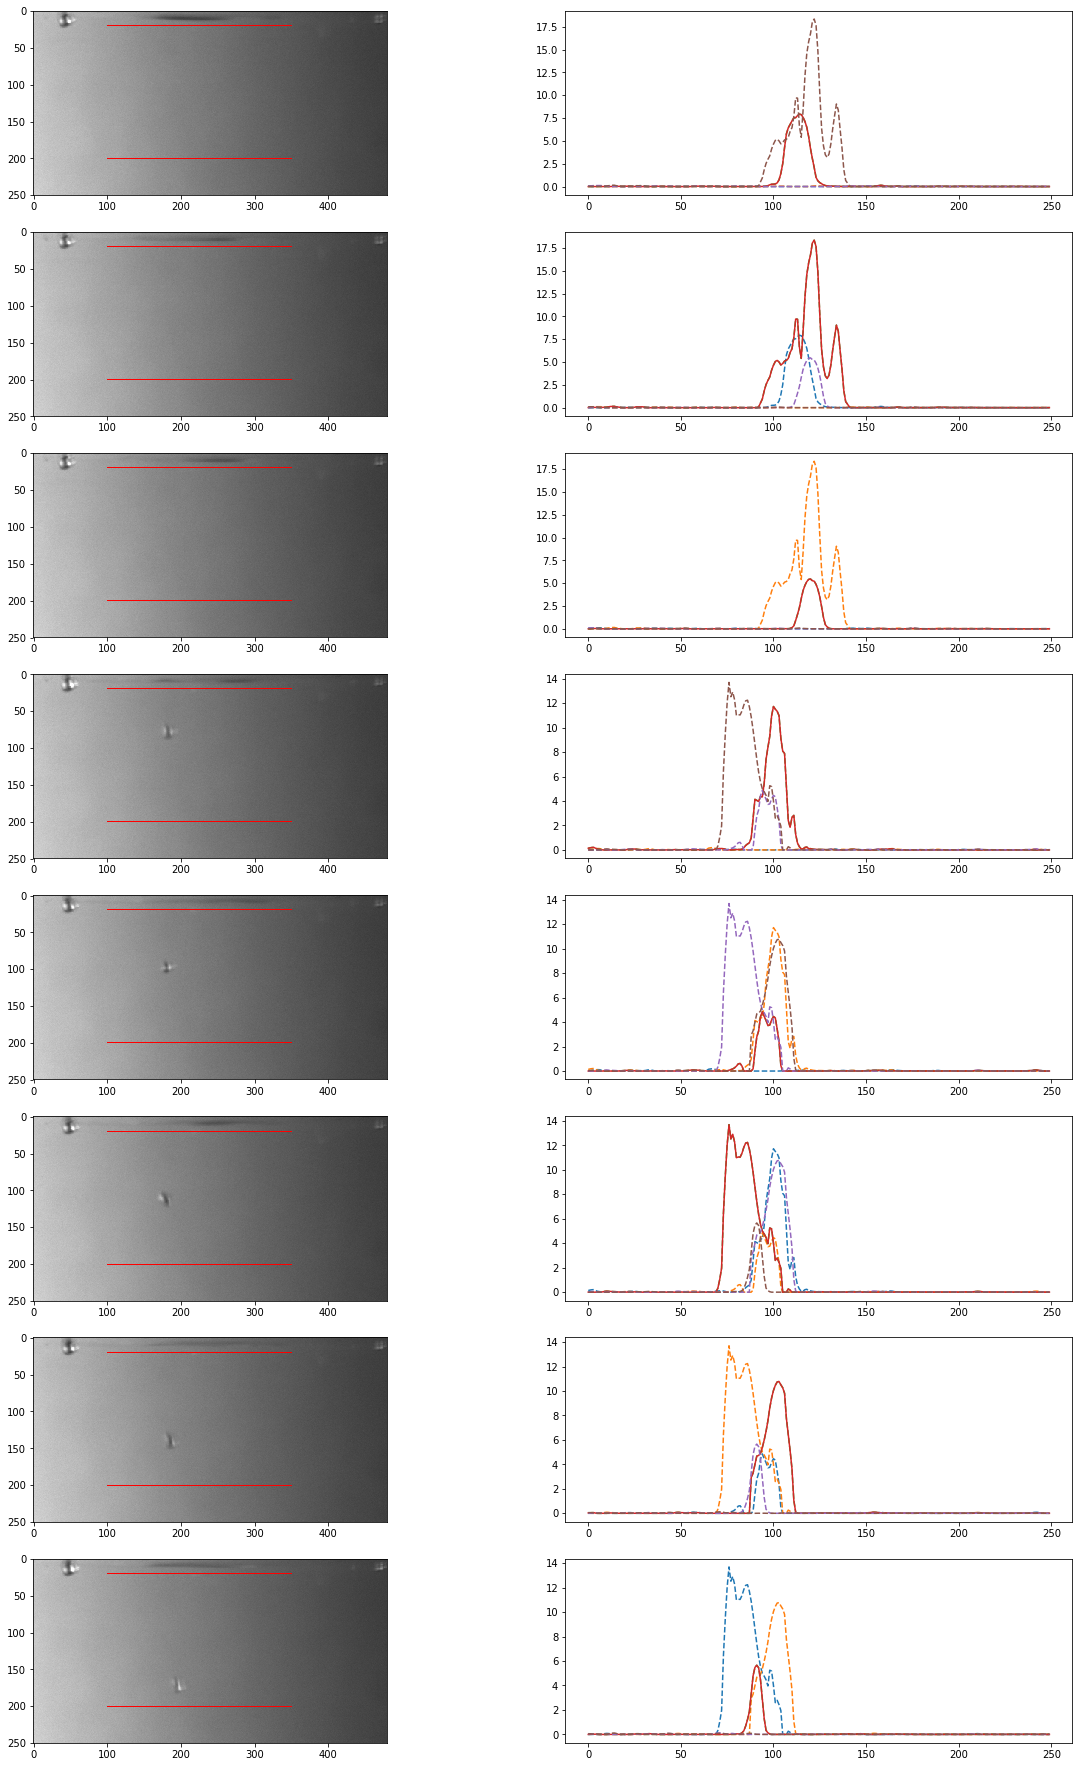

In [253]:
plt.figure(figsize=(20,40))
for i in range(len(time)):
    image=cv2.imread(filenames[init+time[i]])
    image = image[150:400, :]

    cv2.line(image,(100,20),(350,20),(255,0,0),1)
    cv2.line(image,(100,200),(350,200),(255,0,0),1)
    plt.subplot(10,2,2*i+1),plt.imshow(image)
    plt.subplot(10,2,2*i+2)
    for j in range(-2,3):
        plt.plot(bubs_positive[:,time[i]+j],'--')
        if j == 0:
            plt.plot(bubs_positive[:,time[i]+j])
plt.show()

# Documentation fo Optical Flow rutine

Python: cv2.calcOpticalFlowFarneback(prev, next, flow, pyr_scale, levels, winsize, iterations, poly_n, poly_sigma, flags) → flow

Parameters:	

* **prev** – first 8-bit single-channel input image.

* **next** – second input image of the same size and the same type as prev.

* **flow** – computed flow image that has the same size as prev and type CV_32FC2.

* **pyr_scale** – parameter, specifying the image scale ($<1$) to build pyramids for each image; pyr_scale=0.5 means a classical pyramid, where each next layer is twice smaller than the previous one.

* **levels** – number of pyramid layers including the initial image; levels=1 means that no extra layers are created and only the original images are used.

* **winsize** – averaging window size; larger values increase the algorithm robustness to image noise and give more chances for fast motion detection, but yield more blurred motion field.

* **iterations** – number of iterations the algorithm does at each pyramid level.

* **poly_n** – size of the pixel neighborhood used to find polynomial expansion in each pixel; larger values mean that the image will be approximated with smoother surfaces, yielding more robust algorithm and more blurred motion field, typically poly_n =5 or 7.

* **poly_sigma** – standard deviation of the Gaussian that is used to smooth derivatives used as a basis for the polynomial expansion; for poly_n=5, you can set poly_sigma=1.1, for poly_n=7, a good value would be poly_sigma=1.5.

* **flags** – operation flags that can be a combination of the following:

    - **OPTFLOW_USE_INITIAL_FLOW** uses the input flow as an initial flow approximation.

    - **OPTFLOW_FARNEBACK_GAUSSIAN** uses the Gaussian $\texttt{winsize}\times\texttt{winsize}$ filter instead of a box filter of the same size for optical flow estimation; usually, this option gives z more accurate flow than with a box filter, at the cost of lower speed; normally, winsize for a Gaussian window should be set to a larger value to achieve the same level of robustness.

The function finds an optical flow for each prev pixel using the [Farneback2003] algorithm so that
$prev(y,x) \approx next(y+flow(y,x)[1],x+flow(y,x)[0])$